In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import pandas as pd 
import numpy as np 
import torchvision
import torchvision.transforms as transforms
import tqdm
device = torch.device('cuda')

In [2]:
dir = "D:\datasets\MNIST"
train = pd.read_csv(dir+"/train.csv")
test = pd.read_csv(dir+'/test.csv')

In [3]:
labels = train.iloc[:,0]
imgs = train.values[:,1:].reshape((-1, 1, 28, 28))

test = test.values.reshape((-1, 1, 28, 28))

In [4]:
imgs.shape

(42000, 1, 28, 28)

In [14]:
class inputCnn(nn.Module):
    def __init__(self):
        super(inputCnn, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(3, 3))
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        return x

class inputDense(nn.Module):
    def __init__(self, input_shape):
        super(inputDense, self).__init__()
        linear_shape = 1
        for i in input_shape:
            linear_shape *= i

        self.dense1 = nn.Linear(linear_shape, 1000)
        self.dense2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        return x

class outputCnn(nn.Module):
    def __init__(self):
        super(outputCnn, self).__init__()
        self.oconv1 = nn.ConvTranspose2d(in_channels=12, out_channels=6, kernel_size=(3, 3))
        self.oconv2 = nn.ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=(3, 3))

    def forward(self, x):
        x = F.relu(self.oconv1(x))
        x = F.sigmoid(self.oconv2(x))
        return x


class outputDense(nn.Module):
    def __init__(self, input_shape):
        super(outputDense, self).__init__()
        self.output_features = 1

        for i in input_shape:
            self.output_features *= i

        self.dense1 = nn.Linear(10 , 1000)
        self.dense2 = nn.Linear(1000, self.output_features)

    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        return x


In [15]:
class Encoder(nn.Module):
    def __init__(self, image):
        super(Encoder, self).__init__()
        self.CNN = inputCnn().to(device)
        
        temp = self.CNN(image)
        self.Dense = inputDense(input_shape=temp.shape).to(device)

    def forward(self, x):
        xc = self.CNN(x)
        x = torch.flatten(xc, start_dim=1)
        x = self.Dense(x)
        return x, xc

    
class Decoder(nn.Module):
    def __init__(self, image):
        super(Decoder, self).__init__()
        self.intermediate_shape = image.shape

        self.TCNN = outputCnn().to(device)

        self.Dense= outputDense(input_shape=image.shape).to(device)

    def forward(self, x):
        x = self.Dense(x)
        x = torch.reshape(x, (-1, *self.intermediate_shape))
        x = self.TCNN(x)
        return x

Images, singleImage -> Encoder -> Dense output, Intermediate Output -> Decoder -> output Image
                 

In [16]:
class BudgetUNet(nn.Module):
    def __init__(self, sample_input):
        super(BudgetUNet, self).__init__()
        self.encoder = Encoder(sample_input)

        _, temp1 = self.encoder(sample_input)

        self.decoder = Decoder(temp1[0])


    def forward(self, input_image):
        encodings, intermediate_values = self.encoder(input_image)

        output_image = self.decoder(encodings)

        return encodings , output_image

        

In [17]:
input_data = torch.tensor(imgs/255., dtype=torch.float32).to(device)
output_data = torch.flatten(torch.tensor(imgs/255., dtype=torch.float32).to(device), start_dim=1)

test_data = torch.tensor(test/255., dtype=torch.float32).to(device)


In [18]:
from torch.optim import Adam
unet = BudgetUNet(input_data[:1])
optimizer = Adam(unet.parameters(), lr=0.001)
loss_fn= nn.MSELoss()

In [19]:
def train(batch_size= 64, epochs=5):
    
    for e in range(epochs):
        epoch_loss = 0
        with tqdm.trange(0, input_data.shape[0], batch_size, desc=f"Epoch {e+1} / {epochs}") as t:
            for index in t:
                optimizer.zero_grad()
                x = input_data[index: index+batch_size]
                y = output_data[index: index+batch_size]

                encodings, outs = unet(x)
                preds = torch.flatten(outs, start_dim=1)
                loss= loss_fn(preds, y)
                loss.backward()
                epoch_loss += loss.item()
                
                optimizer.step()
                t.set_postfix_str(f"loss: {str(epoch_loss)[:6]}\t")
            validate()
def validate(batch_size=64):
    epoch_loss=0
    with tqdm.trange(0, test_data.shape[0], batch_size, desc=f"Validation") as t:
        for index in t:
            x = test_data[index: index+batch_size]

            encodings, outs = unet(x)
            preds = torch.flatten(outs, start_dim=1)
            y = torch.flatten(x, start_dim=1)

            loss= loss_fn(preds, y)
            epoch_loss += loss.item()
            t.set_postfix_str(f"loss: {str(epoch_loss)[:6]}\t") 
                     

In [20]:
train()

Validation: 100%|████████████████████████████████████████████████████| 438/438 [00:02<00:00, 176.92it/s, loss: 10.298	]


In [21]:
import matplotlib.pyplot as plt 

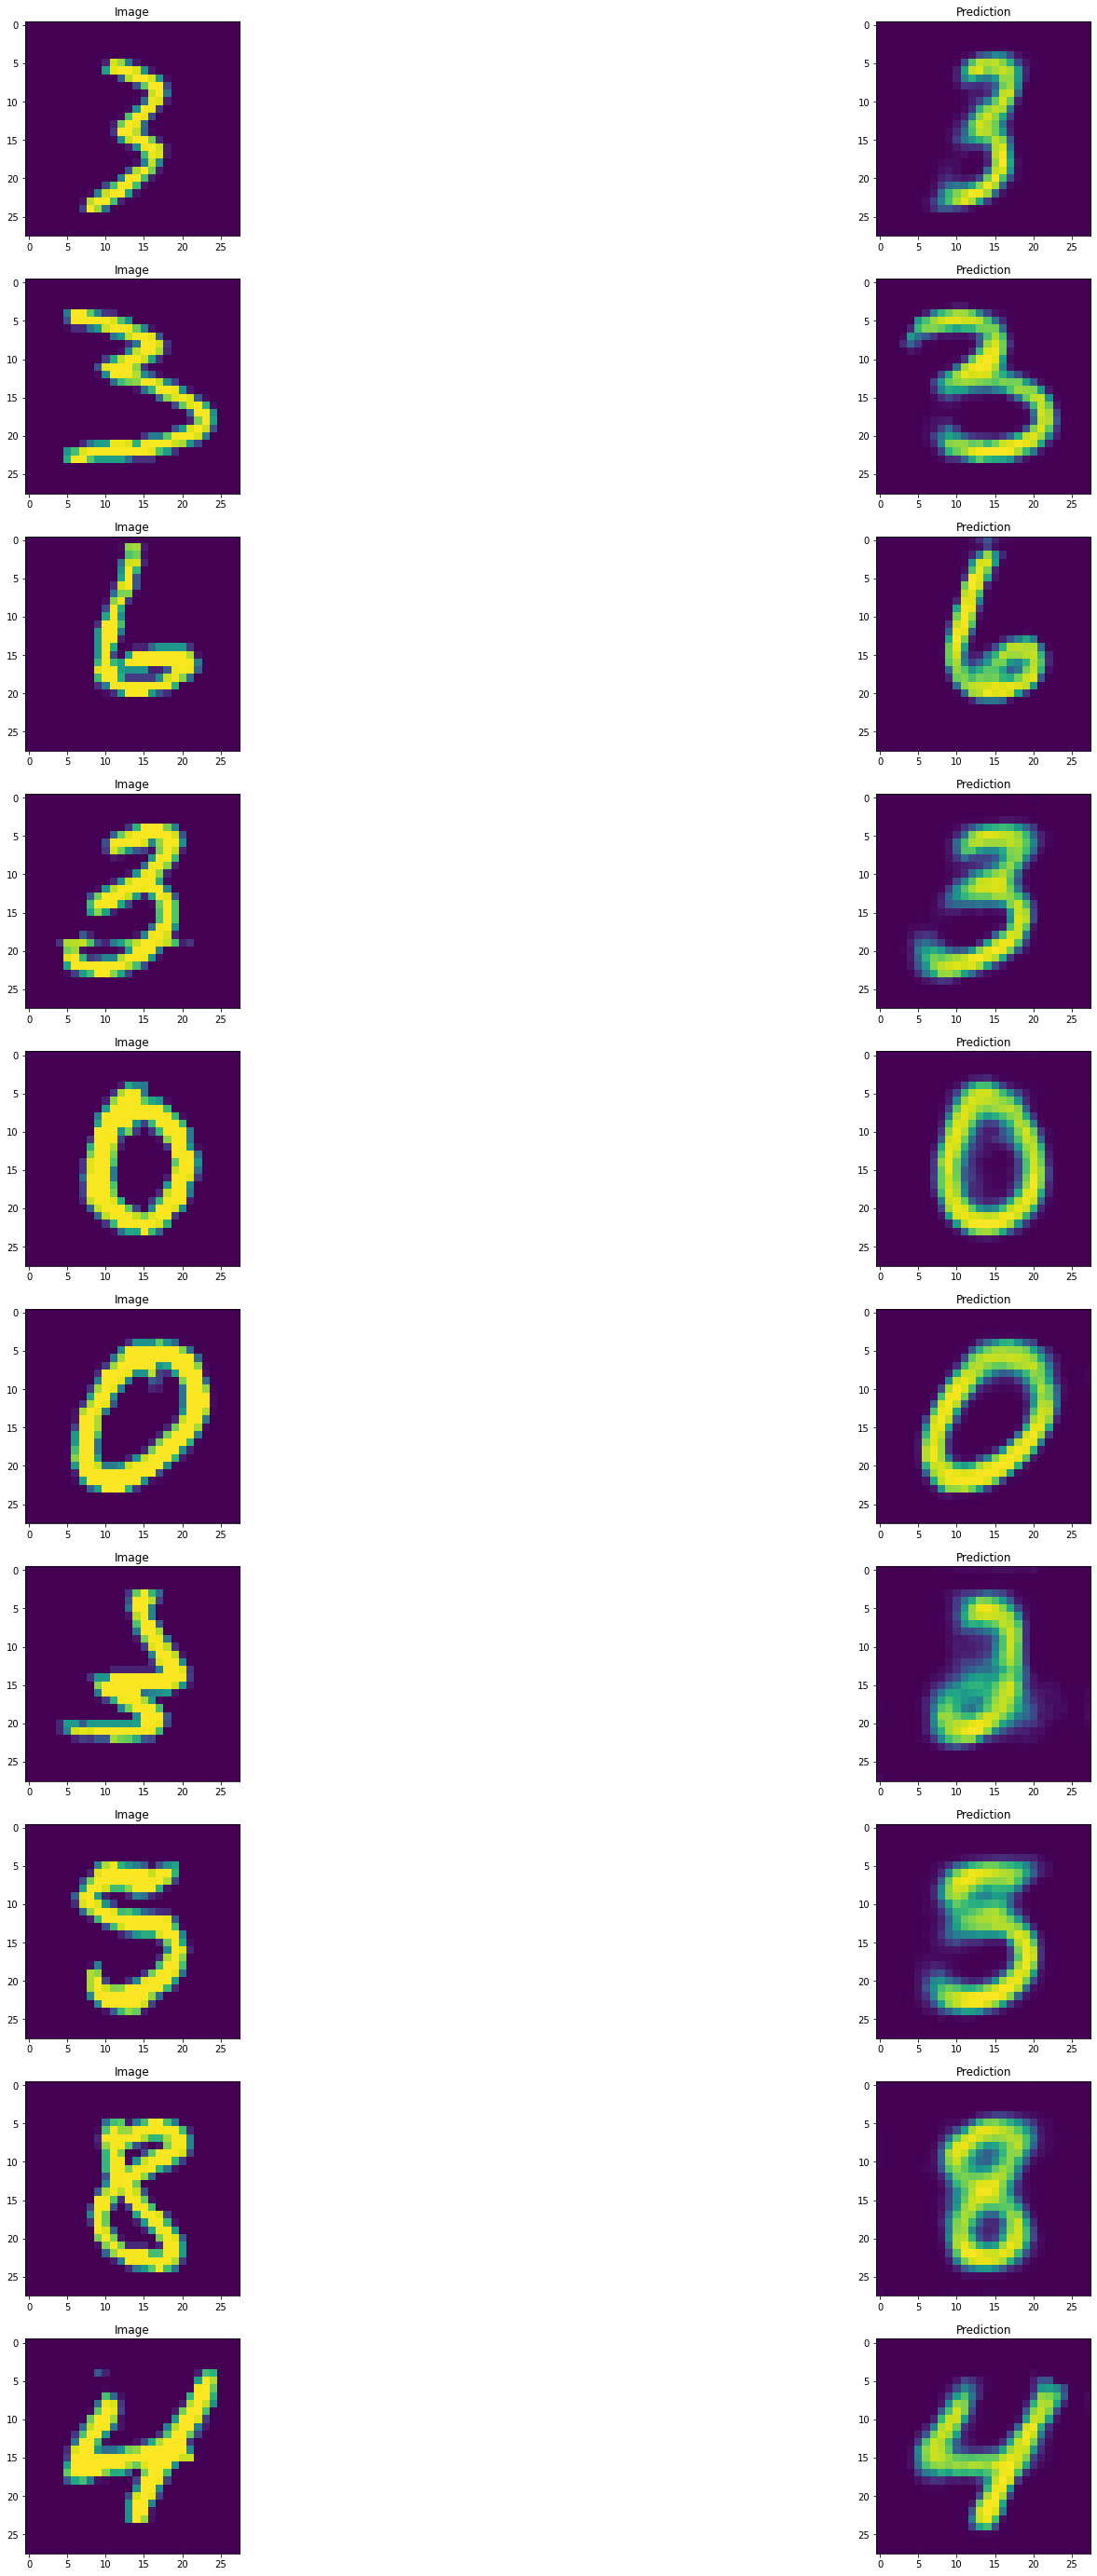

In [22]:
fig = plt.figure(figsize=(30, 50))
j=1
for i in range(10):
    index = np.random.randint(test_data.shape[0])
    
    image = test_data[index].cpu().numpy()
    _, preds = unet(test_data[index: index+1])
    preds = preds.detach().cpu().numpy()[0]
    
    fig.add_subplot(10, 2, j)
    j+=1
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.title("Image")
    
    fig.add_subplot(10, 2, j)
    j+=1
    plt.imshow(np.transpose(preds, (1 ,2 , 0)))
    plt.title("Prediction")
    